# Домашнее задание к лекции "Визуализация данных"

## Обязательная часть

Вам необходимо провести базовый [EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis) выбранного набора данных. 

Требования к анализу:
- построить не менее 4 визуализаций различных видов;
- каждая визуализация должным образом оформлена и читается даже в отрыве от контекста; 
- по каждой визуализации необходимо написать вывод (какую гипотезу на ее основе можно выдвинуть?).

**Откуда брать данные?**

Можете взять свои рабочие данные, либо найти открытые данные (например, на [kaggle.com](https://www.kaggle.com/)) по интересующей вас предметной области (тогда не забудьте их выложить на github вместе с ноутбуком). Если идей нет, можете взять один из перечисленных ниже:
- [данные приложений из Google Play](https://www.kaggle.com/lava18/google-play-store-apps);
- [данные о видео из трендов YouTube](https://www.kaggle.com/datasnaek/youtube-new);
- [данные об уровне счастья в разных странах](https://www.kaggle.com/unsdsn/world-happiness).

### Дополнительная часть (необязательная)

* построить дополнительно не менее 2 визуализаций (итого не менее 6);
* в работе должны присутствовать следующие визуализации: boxplot, heatmap, scatter plot matrix;

In [1]:
import lzma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# describe columns type
dtype = {
    'symbol': 'category',
    'timeframe': 'category',
    'type': 'category',
}
parse_dates = ['open_time', 'close_time']

file = lzma.open('data/trade_results.csv.xz')
trade_results = pd.read_csv(file, dtype=dtype, parse_dates=parse_dates)
trade_results.head()

,symbol,timeframe,type,open_time,open_price,close_time,close_price,profit_in_pips
0,EURUSD,M1,SELL,2017-01-01 22:53:46.482,1.05180,2017-01-01 23:04:08.275,1.05250,-68
1,GBPUSD,M1,BUY,2017-01-01 23:35:18.565,1.23550,2017-01-02 08:15:01.837,1.23330,-223
2,EURCHF,M1,SELL,2017-01-01 23:51:00.126,1.07120,2017-01-02 00:45:28.484,1.07330,-204
3,AUDJPY,M1,SELL,2017-01-01 23:52:14.199,84.19800,2017-01-02 01:25:30.174,84.49200,-294
4,CADCHF,M1,BUY,2017-01-02 00:19:16.166,0.75982,2017-01-02 00:44:28.343,0.75765,-217


# Предобработка данных

In [2]:
# Drop gold and silver trades
trade_results = trade_results[~trade_results.symbol.str.match('XAGUSD|XAUUSD')].reset_index(drop=True)
# Update categories
categories = trade_results['symbol'].unique()
trade_results['symbol'].cat.set_categories(categories, inplace=True)

In [3]:
is_win = lambda x: x > 0
trade_results.loc[:, 'is_win'] = trade_results['profit_in_pips'].transform(is_win)
trade_results.loc[:, 'result_in_pips'] = trade_results['profit_in_pips'].transform(np.abs)
# trade_results['profit_in_pips'].apply((lambda x: x > 0), axis=1)
trade_results.head()

,symbol,timeframe,type,open_time,open_price,close_time,close_price,profit_in_pips,is_win,result_in_pips
0,EURUSD,M1,SELL,2017-01-01 22:53:46.482,1.05180,2017-01-01 23:04:08.275,1.05250,-68,False,68
1,GBPUSD,M1,BUY,2017-01-01 23:35:18.565,1.23550,2017-01-02 08:15:01.837,1.23330,-223,False,223
2,EURCHF,M1,SELL,2017-01-01 23:51:00.126,1.07120,2017-01-02 00:45:28.484,1.07330,-204,False,204
3,AUDJPY,M1,SELL,2017-01-01 23:52:14.199,84.19800,2017-01-02 01:25:30.174,84.49200,-294,False,294
4,CADCHF,M1,BUY,2017-01-02 00:19:16.166,0.75982,2017-01-02 00:44:28.343,0.75765,-217,False,217


# Проанализировать результаты торговли

## Прибыль или убыток

In [4]:
# grouped = trade_results.groupby(['symbol', 'is_win']).agg({'result_in_pips': ['sum']})
grouped = trade_results.groupby(['symbol', 'is_win']).agg({'result_in_pips': ['sum', 'count']})
grouped.head(4)

result_in_pips       
                         sum  count
symbol is_win                      
EURUSD False          298538  12114
       True           236289    954
GBPUSD False          460927  12263
       True           332109    855

### Отобразим столбчатую диаграмму для сравнения прибыли/убытков

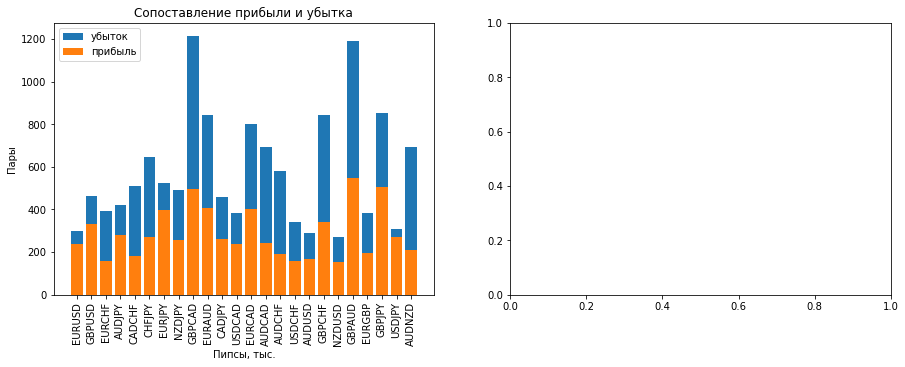

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

# подготавливам значения для X
symbols = trade_results['symbol'].unique()

symbols_win = [(symbol, is_win) for symbol, is_win in grouped.index.values if is_win]
values_win = grouped.loc[symbols_win, ('result_in_pips', 'sum')] / 1000

symbols_loss = [(symbol, is_win) for symbol, is_win in grouped.index.values if not is_win]
values_loss = grouped.loc[symbols_loss, ('result_in_pips', 'sum')] / 1000

# print(symbols_win)
fig, axs = plt.subplots(1,2)
ax1 = axs[0]
p1 = ax1.bar(symbols, values_loss, label='убыток')
p2 = ax1.bar(symbols, values_win, label='прибыль')

ax1.xaxis.set_tick_params(rotation=90)
ax1.set_ylabel('Пары')
ax1.set_xlabel('Пипсы, тыс.')
ax1.title.set_text('Сопоставление прибыли и убытка')
ax1.legend()

plt.show()

#### Выводы:
* По всем инструментам убыток :(
* `USDJPY` и `EURUSD` имеют наименьший убыток по сравнению с остальными

In [6]:
(trade_results
 .groupby('symbol').agg({'profit_in_pips': 'sum'})
 .sort_values('profit_in_pips', ascending=False)
 .head(3))

,profit_in_pips
symbol,
USDJPY,-37701
EURUSD,-62249
NZDUSD,-120595
